In [1]:
from dolfin import *
import numpy as np
import scipy.io

We consider Rayleigh-Benard convection in a rectangular domain ($l_x=0.2, l_y=l_z=0.1$). The boundary conditions of the flow are listed below: the flow is periodic in $x$ and $z$ directions while non-slip boundary conditions are imposed at the two walls. Here we consider two cases: 

1) $Ra=5\times10^4$: the flow approaches to a stationary state with a quasi-two-dimensional flow

2) $Ra=1\times10^5$: the flow approaches to a limit cycle oscillation in steady state. We take a snapshot of the periodic orbit and extract flow structures from the snapshot.

In [2]:
def preprocessingData():
    # load velocity data
    # RB_Re5e4.mat -- quasi-two-dimensional flow
    # RB_Re1e5_0092250 -- unsteady three-dimensional flow
    data = scipy.io.loadmat('RB_Re1e5_0092250.mat')
    xx = data['xgrid']
    yy = data['ygrid']
    zz = data['zgrid']
    xx = xx.flatten()
    yy = yy.flatten()
    zz = zz.flatten()
    nx = xx.shape[0]
    ny = yy.shape[0]
    nz = zz.shape[0]
    vel = data['Velocity']
    vxgrid = vel[:,:,:,0]
    vygrid = vel[:,:,:,1]
    vzgrid = vel[:,:,:,2]

    # check periodic conditions of the augmented data
    df = vxgrid[:,:,nz-1] - vxgrid[:,:,0]
    print('pc vx in x:',max(df.flatten()))
    df = vxgrid[nx-1,:,:] - vxgrid[0,:,:]
    print('pc vx in z:',max(df.flatten()))
    df = vygrid[:,:,nz-1] - vygrid[:,:,0]
    print('pc vy in x:',max(df.flatten()))
    df = vygrid[nx-1,:,:] - vygrid[0,:,:]
    print('pc vy in z:',max(df.flatten()))
    df = vzgrid[:,:,nz-1] - vzgrid[:,:,0]
    print('pc vz in x:',max(df.flatten()))
    df = vzgrid[nx-1,:,:] - vzgrid[0,:,:]
    print('pc vz in z:',max(df.flatten()))
    
    return xx,yy,zz,vxgrid,vygrid,vzgrid

In [3]:
# Sub domain for Dirichlet boundary condition
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return ((near(x[1], 0) or near(x[1], 0.1)) and on_boundary)
    
    
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool ((near(x[0], 0) or near(x[2], 0)) and 
            (not ((near(x[0], 0.2) and near(x[2], 0)) or 
                  (near(x[0], 0) and near(x[2], 0.1)))) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
    	#### define mapping for a edges in the box, such that mapping in 2 Cartesian coordinates are required
        if near(x[0], 0.2) and near(x[2],0.1):
            y[0] = x[0] - 0.2
            y[1] = x[1]
            y[2] = x[2] - 0.1
        #### right maps to left: left/right is defined as the x-direction
        elif near(x[0], 0.2):
            y[0] = x[0] - 0.2
            y[1] = x[1]
            y[2] = x[2]
        #### top maps to bottom: top/bottom is defined as the z-direction        
        elif near(x[2], 0.1):
            y[0] = x[0]
            y[1] = x[1]
            y[2] = x[2] - 0.1
        else:
            y[0] = -10000
            y[1] = -10000
            y[2] = -10000

In [4]:
def eigenvalues(X, V, bc):
#
    # Define the bilinear forms on the right- and left-hand sides
    H = TrialFunction(V)
    h = TestFunction(V)
    a = (inner(X,grad(H))*inner(X, grad(h)))*dx #+inner(H,h)*dx - shift zero eigenvalue
    b = inner(H,h)*dx
#
    # Assemble into PETSc matrices
    #A = PETScMatrix()
    #assemble(a, tensor=A)
    #B = PETScMatrix()
    #assemble(b, tensor=B)
    #bc.apply(A)
    # bc.apply(B) bc.zero(B)
    # v1. bc.apply(A) and bc.apply(B)
    # v2. bc.apply(A) and bc.zero(B)
    # v3. bc.apply(A)
    
    
    dummy = h*dx
    A = PETScMatrix()
    assemble_system(a, dummy, bc, A_tensor=A)
    B = PETScMatrix()
    assemble_system(b, dummy, bc, A_tensor=B)
    # bc.zero(B)
    
    
#
    solver = SLEPcEigenSolver(A, B)
    solver.parameters["solver"] = "krylov-schur"
    solver.parameters["problem_type"] = "gen_hermitian"
#
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = -1e-14 # 0 is not working, 1e-14 or negative number (-0.1) works fine
    neigs = 4
    solver.solve(neigs)
#
    # Return the computed eigenvalues in a sorted array
    computed_eigenvalues = []
    for i in range(min(neigs, solver.get_number_converged())):
        r, _ = solver.get_eigenvalue(i) # ignore the imaginary part
        computed_eigenvalues.append(r)
        print("eigenvalue: ", r)
    # Return the H corresponding to the first and second eigenvalue
    print("return the first eienvector")
    r, c, rx, cx = solver.get_eigenpair(0)
    # Turn the eigenvector into a Function:
    rx_func0 = Function(V)
    rx_func0.vector()[:] = rx
    print("return the second eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func1 = Function(V)
    rx_func1.vector()[:] = rx
    print("return the third eienvector")
    r, c, rx, cx = solver.get_eigenpair(2)
    # Turn the eigenvector into a Function:
    rx_func2 = Function(V)
    rx_func2.vector()[:] = rx
    print("return the fourth eienvector")
    r, c, rx, cx = solver.get_eigenpair(3)
    # Turn the eigenvector into a Function:
    rx_func3 = Function(V)
    rx_func3.vector()[:] = rx
    
    return np.array(computed_eigenvalues), rx_func0, rx_func1, rx_func2, rx_func3

In [5]:
def print_eigenvalues_save_solutions(X,mesh,order,ngrids,xsamp,ysamp,zsamp,pbc):
#
    V   = FunctionSpace(mesh, "Lagrange", order, constrained_domain=pbc)
    #V   = FunctionSpace(mesh, "Lagrange", order)
    u0  = Constant(0.0)
    dbc = DirichletBoundary()
    bc0 = DirichletBC(V, u0, dbc)

    lamd,eiv0,eiv1,eiv2,eiv3 = eigenvalues(X,V,bc0)
    np.set_printoptions(formatter={'float': '{:5.2f}'.format})
    print("Eigenvales:  {}".format(lamd))
#
    # demonstrate the first eigensolution corresponds to constant solution
    print("The first eigensolution is expected to be nonconstant")
    nx = np.size(xsamp)
    ny = np.size(ysamp)
    nz = np.size(zsamp)
    H0 = np.zeros((nx,ny,nz))
    H1 = np.zeros((nx,ny,nz))
    H2 = np.zeros((nx,ny,nz))
    GradH0 = np.zeros((nx,ny,nz,3))
    GradH1 = np.zeros((nx,ny,nz,3))
    gradeiv0 = grad(eiv0)
    Gradeiv0 = project(gradeiv0,solver_type='iterative')
    gradeiv1 = grad(eiv1)
    Gradeiv1 = project(gradeiv1,solver_type='iterative')
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                H0[i,j,k] = eiv0(xsamp[i],ysamp[j],zsamp[k])
                H1[i,j,k] = eiv1(xsamp[i],ysamp[j],zsamp[k])
                H2[i,j,k] = eiv2(xsamp[i],ysamp[j],zsamp[k])
                gradh0ijk = Gradeiv0(xsamp[i],ysamp[j],zsamp[k])
                gradh1ijk = Gradeiv1(xsamp[i],ysamp[j],zsamp[k])
                GradH0[i,j,k,:] = gradh0ijk
                GradH1[i,j,k,:] = gradh1ijk

    h0 = H0.flatten()
    dh0 = max(h0)-min(h0)
    print("range of H0: ", dh0)
    h1 = H1.flatten()
    dh1 = max(h1)-min(h1)
    print("range of H1: ", dh1)
    import os
    dirname = 'RBCnx'+str(ngrids[0])+'ny'+str(ngrids[1])+'nz'+str(ngrids[2])+'order'+str(order)+'DPBC1e5' # DPBCD1e5_0092250  BarrierDPBCD
    isFile = os.path.isdir(dirname) 
    if not isFile:
        os.mkdir(dirname)
#    
    # contour plot of H at sections x=0, y=0 and z=0
    from matplotlib import pyplot as plt
    lx = 0
    yy,zz=np.meshgrid(ysamp,zsamp)
    plt.figure()
    plt.contour(yy,zz,H0[np.argmin(abs(xsamp-lx)),:,:].T,100)
    plt.colorbar()   
    plt.xlabel('y'); plt.ylabel('z')
    plt.title('x=0 (first mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/x1.png')
    plt.figure()
    plt.contour(yy,zz,H1[np.argmin(abs(xsamp-lx)),:,:].T,100)
    plt.colorbar()  
    plt.xlabel('y'); plt.ylabel('z')
    plt.title('x=0 (second mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/x2.png')
    plt.figure()
    plt.contour(yy,zz,H2[np.argmin(abs(xsamp-lx)),:,:].T,100)
    plt.colorbar()  
    plt.xlabel('y'); plt.ylabel('z')
    plt.title('x=0 (third mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/x3.png')
    
    xx,zz=np.meshgrid(xsamp,zsamp)
    hy = H0[:,np.argmin(abs(ysamp-0.05)),:];
    hy = np.reshape(hy,[nx,nz],order='F');
    plt.figure();
    plt.contour(xx,zz,hy.T,100)
    plt.colorbar()
    plt.xlabel('x'); plt.ylabel('z')
    plt.title('y=0 (first mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/y1.png')
    hy = H1[:,np.argmin(abs(ysamp-0.05)),:];
    hy = np.reshape(hy,[nx,nz],order='F');
    plt.figure();
    plt.contour(xx,zz,hy.T,100)
    plt.colorbar()
    plt.xlabel('x'); plt.ylabel('z')
    plt.title('y=0 (second mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/y2.png')
    hy = H2[:,np.argmin(abs(ysamp-0.05)),:];
    hy = np.reshape(hy,[nx,nz],order='F');
    plt.figure();
    plt.contour(xx,zz,hy.T,100)
    plt.colorbar()
    plt.xlabel('x'); plt.ylabel('z')
    plt.title('y=0 (third mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/y3.png') 
    
    lz = 0
    hz = H0[:,:,np.argmin(abs(zsamp-lz))];
    hz = np.reshape(hz,[nx,ny],order='F');
    xx,yy=np.meshgrid(xsamp,ysamp)
    plt.figure();
    plt.contour(xx,yy,hz.T,100)
    plt.colorbar()
    plt.xlabel('x'); plt.ylabel('y')
    plt.title('z=0 (first mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/z1.png')
  
    hz = H1[:,:,np.argmin(abs(zsamp-lz))];
    hz = np.reshape(hz,[nx,ny],order='F');
    xx,yy=np.meshgrid(xsamp,ysamp)
    plt.figure();
    plt.contour(xx,yy,hz.T,100)
    plt.colorbar()
    plt.xlabel('x'); plt.ylabel('y')
    plt.title('z=0 (second mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/z2.png')
    
    hz = H2[:,:,np.argmin(abs(zsamp-lz))];
    hz = np.reshape(hz,[nx,ny],order='F');
    xx,yy=np.meshgrid(xsamp,ysamp)
    plt.figure();
    plt.contour(xx,yy,hz.T,100)
    plt.colorbar()
    plt.xlabel('x'); plt.ylabel('y')
    plt.title('z=0 (third mode)')
    ax = plt.gca()
    ax.set_aspect('equal','box')
    plt.savefig(dirname+'/z3.png')
#    
    # save solution as matlab compatible file
    mdic = {"x": xsamp, "y": ysamp, "z": zsamp, "lambda": lamd, "H1": H0, "H2": H1, "GradH1": GradH0, "GradH2": GradH1,"numDOF": V.dim(),"numEle": mesh.num_cells()}
    from scipy.io import savemat
    savemat(dirname,mdic)
    
    return eiv1

In [6]:
def reconstructVelocityFieldsFromData(mesh,vInterpolator,V):
    # extract mesh coordinates
    coor = mesh.coordinates()
    dims = coor.shape
    v_vals = np.zeros(dims)
    for i in range(dims[1]):
        v_vals[:,i] = vInterpolator[i](coor) # interpolation at grid points 

    parameters["reorder_dofs_serial"] = False
    V1 = FunctionSpace(mesh, "Lagrange", 1)
    vx_construct = Function(V1)
    vy_construct = Function(V1)
    vz_construct = Function(V1)
    vx_vals = v_vals[:,0]
    vy_vals = v_vals[:,1]
    vz_vals = v_vals[:,2]
    vx_construct.vector()[:] = vx_vals[vertex_to_dof_map(V1)]
    vy_construct.vector()[:] = vy_vals[vertex_to_dof_map(V1)]
    vz_construct.vector()[:] = vz_vals[vertex_to_dof_map(V1)]
    print('reconstruction error at x: ', vx_construct(0.05,0.08,0.1)-vInterpolator[0]([0.05,0.08,0.1]))
    print('reconstruction error at y: ', vy_construct(0.05,0.08,0.1)-vInterpolator[1]([0.05,0.08,0.1]))
    print('reconstruction error at z: ', vz_construct(0.05,0.08,0.1)-vInterpolator[2]([0.05,0.08,0.1]))
    
    return as_vector([vx_construct,vy_construct,vz_construct])
    # project function from V1 to V
    vx_l2 = project(vx_construct,V)
    vy_l2 = project(vy_construct,V)
    vz_l2 = project(vz_construct,V)
    print('projection error at x: ', vx_l2(0.05,0.08,0.1)-vx_construct(0.05,0.08,0.1))
    print('projection error at y: ', vy_l2(0.05,0.08,0.1)-vy_construct(0.05,0.08,0.1))
    print('projection error at z: ', vz_l2(0.05,0.08,0.1)-vz_construct(0.05,0.08,0.1))
    
    return as_vector([vx_l2,vy_l2,vz_l2])

In [7]:
from scipy.interpolate import RegularGridInterpolator
# velocity data at grids - this data will be provided in channelflow
xx,yy,zz,vxgrid,vygrid,vzgrid = preprocessingData()
vx_interpolation = RegularGridInterpolator((xx, yy, zz), vxgrid)
vy_interpolation = RegularGridInterpolator((xx, yy, zz), vygrid)
vz_interpolation = RegularGridInterpolator((xx, yy, zz), vzgrid)
v_interpolation  = [vx_interpolation,vy_interpolation,vz_interpolation]

pc vx in x: 0.000537374
pc vx in z: 0.00162753
pc vy in x: 0.000806699
pc vy in z: 0.000319137
pc vz in x: 0.000481071
pc vz in z: 0.000285211


***************************************************
computation at order 2 and 30 grid points
reconstruction error at x:  [  1.73472348e-18]
reconstruction error at y:  [ -3.46944695e-18]
reconstruction error at z:  [ -3.03576608e-18]
eigenvalue:  5.051865001699002e-06
eigenvalue:  6.873035676841449e-06
eigenvalue:  3.139185554597891e-05
eigenvalue:  5.3839506221989976e-05
return the first eienvector
return the second eienvector
return the third eienvector
return the fourth eienvector
Eigenvales:  [ 0.00  0.00  0.00  0.00]
The first eigensolution is expected to be nonconstant
range of H0:  114.719493148
range of H1:  127.195086857


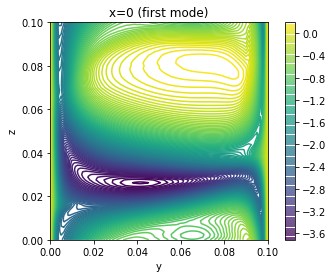

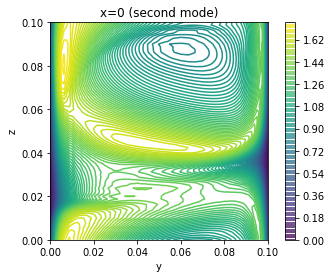

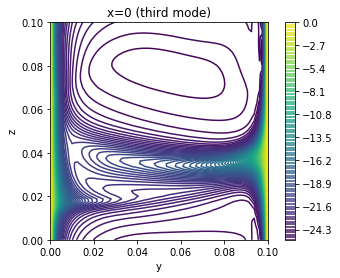

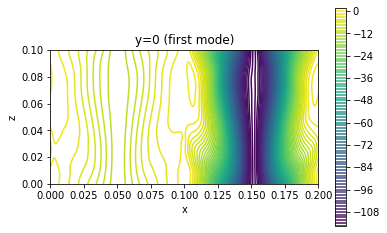

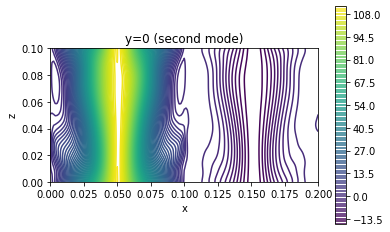

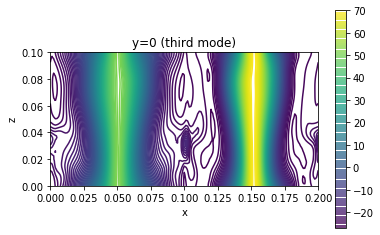

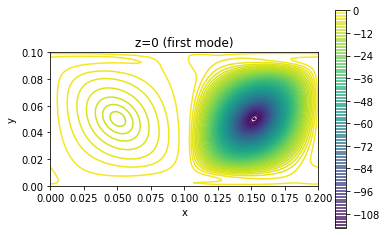

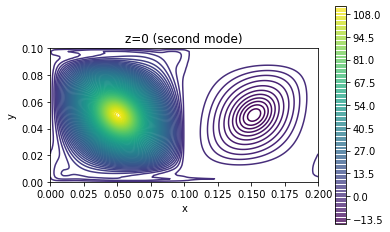

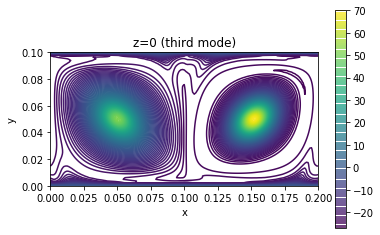

In [8]:
# set up problem
order = 2
numGrids = np.array([30]) 
xsamp = np.linspace(0,0.2,161) # evaluation of H for plotting
ysamp = np.linspace(0,0.1,81) 
zsamp = np.linspace(0,0.1,81) 
ax = 0.2
az = 0.1
# loop over number of grids
for idx in numGrids:
    print('***************************************************')
    print('computation at order',order,'and',idx,'grid points')
    ngridx = 2*idx
    ngridy = idx
    ngridz = idx
    ngrids = np.array([ngridx,ngridy,ngridz])
    mesh = BoxMesh(Point(0,0,0), Point(ax,0.1,az), ngridx, ngridy, ngridz)
    ## Define boundary condition
    pbc = PeriodicBoundary()
    # reconstruct X
    V  = FunctionSpace(mesh, "Lagrange", order, constrained_domain=pbc)
    Xr = reconstructVelocityFieldsFromData(mesh,v_interpolation,V)
    # call print_eigenvalues_save_solutions(X,mesh,order,xsamp,ysamp,zsamp)
    eiv1 = print_eigenvalues_save_solutions(Xr,mesh,order,ngrids,xsamp,ysamp,zsamp,pbc)